# Feed-forward, CPM+log-transform

https://pmc.ncbi.nlm.nih.gov/articles/instance/10339462/bin/NIHMS1794952-supplement-supp1-3021387.pdf

https://pmc.ncbi.nlm.nih.gov/articles/PMC10339462/#SM1

In [144]:
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from tqdm import tqdm
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

rna_seq_data_path = Path(config["genomics"]["rna_seq_count"])
metadata = pd.read_csv(rna_seq_data_path / "metadata.csv")

clinical_metadata = pd.read_csv(config["clinical"]["cleaned_clinical_267"])
filter_267_subjects = clinical_metadata["submitter_id"].values
metadata = metadata[metadata["case_id"].isin(filter_267_subjects)] # only 265 subjects have rnaseq data

## Preprocess

CPM + log-transform

In [2]:
# collect cases with samples and cases with labels
cases = metadata["case_id"].unique()
cases_many_samples = [c for c, n_samples in Counter(metadata["case_id"]).items() if n_samples > 1]
cases_files = {}
for case in cases:
    cases_files[case] = metadata[metadata["case_id"] == case]["file_name"].values

def process_one_case(case_id, case_files, data_dir=rna_seq_data_path):
    """
    read files/samples for a case and
    aggregates data for that case
    """
    # initialize the dataframe
    selected_cols = ["gene_id", "log_cpm_unstranded"]
    concat_data = pd.DataFrame(columns=selected_cols)
    
    # process each tsv_file for a case
    for tsv_file in case_files:
        data = pd.read_csv(data_dir / tsv_file, sep='\t', header=1)
        data = data[data["gene_type"] == "protein_coding"][["gene_id", "unstranded"]]
        # calculate CPM
        data["cpm_unstranded"] = (data["unstranded"] / data["unstranded"].sum()) * 1e6
        # calculate log-transform on CPM     
        data["log_cpm_unstranded"] = np.log1p(data["cpm_unstranded"])
        # select only gene_id and log_cpm_unstranded columns
        data = data[["gene_id", "log_cpm_unstranded"]]
        concat_data = pd.concat([concat_data, data], ignore_index=True)

    # aggregate the samples and transpose (prep for patient-gene matrix later)
    aggregated_data = concat_data.groupby("gene_id").mean().reset_index()
    aggregated_data = aggregated_data.rename(columns={selected_cols[1]: case_id})

    return aggregated_data


def process_all_cases_parallel(cases_files, max_workers=8):
    """
    outputs a case-gene matrix (like above, but in parallel)
    """
    gene_case_matrix = pd.DataFrame(columns=["gene_id"])

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_case = {executor.submit(process_one_case, case_id, case_files): case_id for case_id, case_files in cases_files.items()}
        
        for future in tqdm(as_completed(future_to_case), total=len(future_to_case)):
            case_id = future_to_case[future]
            case_data = future.result()
            if case_data is not None:
                gene_case_matrix = gene_case_matrix.merge(case_data, on="gene_id", how="outer")

    # transpose the matrix
    case_gene_matrix = gene_case_matrix.set_index("gene_id").T.reset_index().rename_axis(None, axis=1)
    case_gene_matrix.columns.values[0] = "case_id"
    return case_gene_matrix

In [3]:
case_gene_matrix = process_all_cases_parallel(cases_files)

100%|██████████| 265/265 [00:20<00:00, 12.71it/s]


## Add time/event

In [4]:
time_event = clinical_metadata[["time", "event", "submitter_id"]]
full_data = pd.merge(case_gene_matrix, time_event, left_on="case_id", right_on="submitter_id").drop("submitter_id", axis=1)

## Loss function

In [5]:
################
# Survival Utils
################
def CoxLoss(survtime, censor, hazard_pred, device):
    # This calculation credit to Travers Ching https://github.com/traversc/cox-nnet
    # Cox-nnet: An artificial neural network method for prognosis prediction of high-throughput omics data
    current_batch_len = len(survtime)
    R_mat = np.zeros([current_batch_len, current_batch_len], dtype=int)
    for i in range(current_batch_len):
        for j in range(current_batch_len):
            R_mat[i,j] = survtime[j] >= survtime[i]

    R_mat = torch.FloatTensor(R_mat).to(device)
    theta = hazard_pred.reshape(-1)
    exp_theta = torch.exp(theta)
    loss_cox = -torch.mean((theta - torch.log(torch.sum(exp_theta*R_mat, dim=1))) * censor)
    return loss_cox


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)


def accuracy_cox(hazardsdata, labels):
    # This accuracy is based on estimated survival events against true survival events
    median = np.median(hazardsdata)
    hazards_dichotomize = np.zeros([len(hazardsdata)], dtype=int)
    hazards_dichotomize[hazardsdata > median] = 1
    correct = np.sum(hazards_dichotomize == labels)
    return correct / len(labels)


def cox_log_rank(hazardsdata, labels, survtime_all):
    median = np.median(hazardsdata)
    hazards_dichotomize = np.zeros([len(hazardsdata)], dtype=int)
    hazards_dichotomize[hazardsdata > median] = 1
    idx = hazards_dichotomize == 0
    T1 = survtime_all[idx]
    T2 = survtime_all[~idx]
    E1 = labels[idx]
    E2 = labels[~idx]
    results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    pvalue_pred = results.p_value
    return(pvalue_pred)


def CIndex(hazards, labels, survtime_all):
    concord = 0.
    total = 0.
    N_test = labels.shape[0]
    for i in range(N_test):
        if labels[i] == 1:
            for j in range(N_test):
                if survtime_all[j] > survtime_all[i]:
                    total += 1
                    if hazards[j] < hazards[i]: concord += 1
                    elif hazards[j] < hazards[i]: concord += 0.5

    return(concord/total)


def CIndex_lifeline(hazards, labels, survtime_all):
    return(concordance_index(survtime_all, -hazards, labels))

## Model

Model configuration: 
 "Lastly, our Genomic SNN consists of 4 consecutive blocks of fully-connected layers with dimensions [64, 48, 32, 32], ELU activation, and
Alpha Dropout. For survival outcome prediction, all networks were activated using the Sigmoid function, with the output scaled
to be between -3 and 3. For grade classification, all networks were activated using the Log Softmax to compute scores for each
of the 3 WHO Grades"

Loss function: partial negative log-likelihood (cox hazard proportional)

In [6]:
def init_max_weights(module):
    for m in module.modules():
        if type(m) == nn.Linear:
            stdv = 1. / math.sqrt(m.weight.size(1))
            m.weight.data.normal_(0, stdv)
            m.bias.data.zero_()

## Help Model


In [7]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
# ---------------------------
# Cox partial negative log loss Function
# ---------------------------
def CoxLoss(survtime, censor, hazard_pred, device):
    """
    computes the Cox partial likelihood loss
    - survtime: survival times (batch tensor)
    - censor: event indicators (1 if event occurred, 0 if censored)
    - hazard_pred: predicted hazard scores (batch tensor)
    """
    current_batch_len = len(survtime)

    # Build risk set indicator matrix: R[i,j] = 1 if survtime[j] >= survtime[i]
    R_mat = np.zeros([current_batch_len, current_batch_len], dtype=int)
    for i in range(current_batch_len):
        for j in range(current_batch_len):
            R_mat[i, j] = survtime[j] >= survtime[i]
    R_mat = torch.FloatTensor(R_mat).to(device)

    theta = hazard_pred.view(-1)  # flatten predictions
    exp_theta = torch.exp(theta)

    # negative log partial likelihood weighted by event indicators
    loss_cox = -torch.mean((theta - torch.log(torch.sum(exp_theta * R_mat, dim=1))) * censor)
    return loss_cox

# ---------------------------
# custom c-index
# ---------------------------
def concordance_index(hazards, times, events):
    """
    computes the c-index for survival prediction
    - hazards: predicted risk scores (higher means higher risk)
    - times: observed survival times
    - events: event indicators (1 if event occurred, 0 if censored)
    """
    n = len(times)
    concordant = 0.0
    permissible = 0.0
    for i in range(n):
        for j in range(n):
            # nly compare if i had an event and its time is earlier than j
            if times[i] < times[j] and events[i] == 1:
                permissible += 1
                if hazards[i] > hazards[j]:
                    concordant += 1
                elif hazards[i] == hazards[j]:
                    concordant += 0.5
    return concordant / permissible if permissible > 0 else 0

# ---------------------------
# Custom Weight Initialization
# ---------------------------
def init_max_weights(module):
    """
    ccustom weight initialization for all Linear layers.
    """
    for m in module.modules():
        if isinstance(m, nn.Linear):
            stdv = 1. / math.sqrt(m.weight.size(1))
            m.weight.data.normal_(0, stdv)
            if m.bias is not None:
                m.bias.data.zero_()

# ---------------------------
# dataset loader
# ---------------------------
class GenomicDataset(Dataset):
    def __init__(self, dataframe):
        """
        dataset for survival analysis with genomic data
        args:
            dataframe with columns for gene expressions, 'time', and 'event'
        """
        self.data = dataframe.copy()
        # Identify gene expression columns (exclude identifiers and survival columns)
        self.gene_columns = [col for col in self.data.columns if col not in ['case_id', 'time', 'event']]
        # Convert gene columns to floats
        self.data[self.gene_columns] = self.data[self.gene_columns].astype(float)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get the row and convert gene expression features to tensor
        sample = self.data.iloc[idx]
        num_gene_values = sample[self.gene_columns].astype(float).to_numpy()
        x_omic = torch.tensor(num_gene_values, dtype=torch.float32)
        time = torch.tensor(sample['time'], dtype=torch.float32)
        event = torch.tensor(sample['event'], dtype=torch.float32)  # 1: event occurred; 0: censored
        return x_omic, time, event


In [ ]:
# ---------------------------
# define model
# ---------------------------
class RnaNN(nn.Module):
    def __init__(self, input_dim, omic_dim=32, dropout_rate=0.25, act=None, label_dim=1, init_max=True):
        """
        args:
            input_dim: Number of input gene expression features
            omic_dim: Dimension of the latent (encoded) feature space
            dropout_rate: Dropout probability (AlphaDropout used here)
            act: Activation function applied to the output ( nn.Sigmoid)
            label_dim: Output dimension (1 for hazard score)
            init_max: If True, applies custom weight initialization
        """
        super(RnaNN, self).__init__()
        
        hidden = [64, 48, 32, 32]
        self.act = act

        # encoder: series of FCLinear -> ELU -> AlphaDropout layers
        self.encoder = nn.Sequential(
            nn.Sequential(nn.Linear(input_dim, hidden[0]), nn.ELU(), nn.AlphaDropout(p=dropout_rate)),
            nn.Sequential(nn.Linear(hidden[0], hidden[1]), nn.ELU(), nn.AlphaDropout(p=dropout_rate)),
            nn.Sequential(nn.Linear(hidden[1], hidden[2]), nn.ELU(), nn.AlphaDropout(p=dropout_rate)),
            nn.Sequential(nn.Linear(hidden[2], omic_dim), nn.ELU(), nn.AlphaDropout(p=dropout_rate))
        )
        # classifier: maps latent features to a hazard score
        self.classifier = nn.Sequential(nn.Linear(omic_dim, label_dim))
        
        if init_max:
            init_max_weights(self)  #custom initialization

        # If using a Sigmoid activation, these parameters rescale the output
        self.output_range = Parameter(torch.FloatTensor([6]), requires_grad=False)
        self.output_shift = Parameter(torch.FloatTensor([-3]), requires_grad=False)

    def forward(self, x_omic):
        """
        Forward pass:
          - x_omic: tensor of genomic features.
          Returns encoded features and the final hazard score prediction.
        """
        features = self.encoder(x_omic)  # Extract latent features
        out = self.classifier(features)   # Compute hazard score
        if self.act is not None:
            out = self.act(out)
            # Rescale output if Sigmoid is used
            if isinstance(self.act, nn.Sigmoid):
                out = out * self.output_range + self.output_shift

        return features, out


In [ ]:
# ---------------------------
# data prep
# ---------------------------
np.random.seed(123)
torch.manual_seed(123)
random.seed(123)

# 80% for train and 20% for valid
train_df, val_df = train_test_split(full_data, test_size=0.2, random_state=123)

train_dataset = GenomicDataset(train_df)
val_dataset = GenomicDataset(val_df)

# data loader to iterate over in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ---------------------------
# initializations
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = len(train_dataset.gene_columns)  
print("device:", device)
print("input_dim:", input_dim)

model = RnaNN(input_dim=input_dim, omic_dim=32, dropout_rate=0.25, act=None, label_dim=1, init_max=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002) # training is very sensitive to lr

device: cuda
input_dim: 19962


In [ ]:
# ---------------------------
# training 
# ---------------------------
num_epochs = 8  

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for x_omic, time, event in train_loader:
        
        x_omic = x_omic.to(device)
        time = time.to(device)
        event = event.to(device)
        
        # predicted hazard scores
        _, hazard_pred = model(x_omic)
        
        # Cox loss using survival time and event indicators
        loss = CoxLoss(time, event, hazard_pred, device)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * x_omic.size(0)
    
    epoch_loss /= len(train_dataset)
    print(f"epoch {epoch+1}/{num_epochs}, loss: {epoch_loss}")

epoch 1/8, loss: 3.224676343629945
epoch 2/8, loss: 2.965063751868482
epoch 3/8, loss: 1.871668224064809
epoch 4/8, loss: 1.5236212037644297
epoch 5/8, loss: 0.9624298136189299
epoch 6/8, loss: 0.959044727514375
epoch 7/8, loss: 0.9007221803350268
epoch 8/8, loss: 0.876247116979563


In [ ]:
# ---------------------------
# validation 
# ---------------------------
model.eval()
all_hazards = []
all_times = []
all_events = []

with torch.no_grad():
    # Loop over validation DataLoader to collect predictions and true outcomes
    for x_omic, time, event in val_loader:
        x_omic = x_omic.to(device)
        time = time.to(device)
        event = event.to(device)
        _, hazard_pred = model(x_omic)
        # Store predictions and labels (flatten hazard predictions to a 1D array)
        all_hazards.append(hazard_pred.view(-1).cpu().numpy())
        all_times.append(time.cpu().numpy())
        all_events.append(event.cpu().numpy())

# concatenate all batches
all_hazards = np.concatenate(all_hazards)
all_times = np.concatenate(all_times)
all_events = np.concatenate(all_events)


c_index = concordance_index(all_hazards, all_times, all_events)
print("validation c-index:", c_index)

validation c-index: 0.6919945725915875


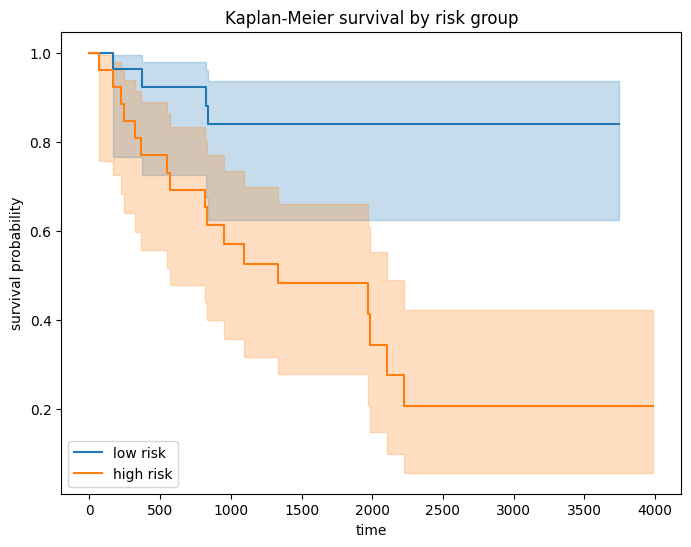

Log-rank test p-value: 0.0017345737020277644


In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ---------------------------
# KM curves and log-rank test
# ---------------------------

# dichotomize patients into low- and high-risk groups based on the median hazard

median_hazard = np.median(all_hazards)
# masking low and high risk groupd based on median hazard
low_risk_mask = all_hazards <= median_hazard
high_risk_mask = all_hazards > median_hazard

# KM curves for each group
kmf_low = KaplanMeierFitter()
kmf_high = KaplanMeierFitter()

# fitting
kmf_low.fit(all_times[low_risk_mask], event_observed=all_events[low_risk_mask], label='low risk')
kmf_high.fit(all_times[high_risk_mask], event_observed=all_events[high_risk_mask], label='high risk')

plt.figure(figsize=(10, 8))

ax = plt.subplot(111)
kmf_low.plot_survival_function(ax=ax, ci_show=True)
kmf_high.plot_survival_function(ax=ax, ci_show=True)

plt.title('Kaplan-Meier survival by risk group')
plt.xlabel('time')
plt.ylabel('survival probability')
plt.legend()
plt.show()


# log-rank test evaluates if the survival curves of the two groups are statistically different
logrank_test = logrank_test(all_times[low_risk_mask], all_times[high_risk_mask],
                       event_observed_A=all_events[low_risk_mask],
                       event_observed_B=all_events[high_risk_mask])

print("log-rank test p-value", logrank_test.p_value)


# Simple baseline model

And likely more effective

- CPM+log, dim reduction, uses these features to input into a baseline linear Cox model
- CPM+log, no dim reduction, baseline linear cox => crash
- CPM+log, random forest

## CPM+Log, PCA

training c-index: 0.6903122694861077
Log-likelihood: -283.4525322140991
AIC partial: 570.9050644281982


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pc1,0.022203,1.022451,0.004531,0.013321,0.031084,1.013411,1.031572,0.0,4.899830,9.591943e-07,19.991674
pc2,-0.017299,0.982850,0.006345,-0.029734,-0.004863,0.970703,0.995148,0.0,-2.726473,6.401525e-03,7.287369


validation c-index: 0.32884902840059793


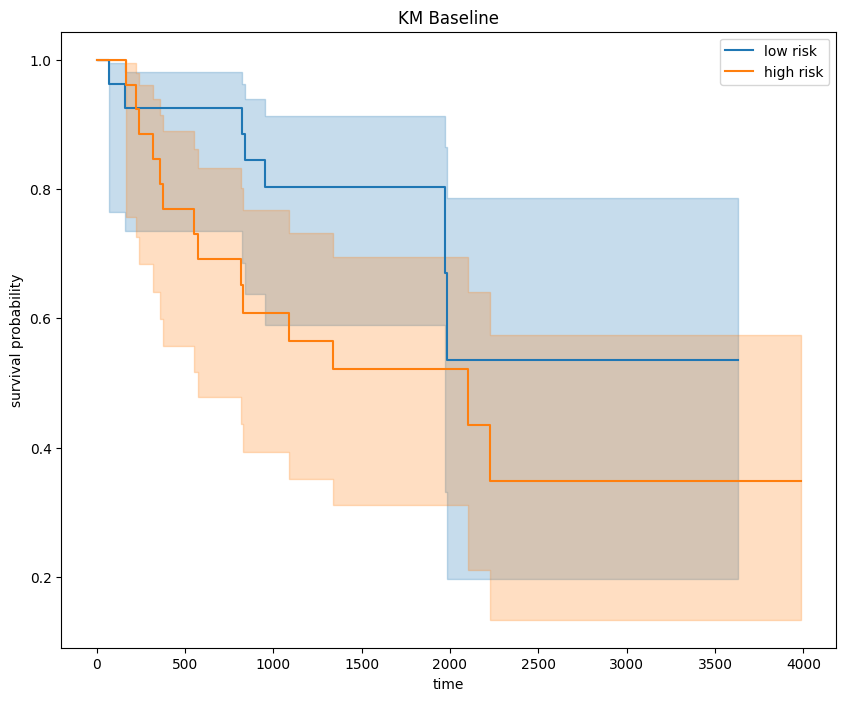

Log-rank Test p-value 0.08730425505201546


In [147]:
# this matrix is already preprocessed with CPM and log-transformed
# now, we will reduce the dimensionality simply using PCA

from sklearn.decomposition import PCA
np.random.seed(123)
torch.random.manual_seed(123)
random.seed(123)

# prepare inputs
n_components = 2
features_pca = PCA(n_components=n_components).fit_transform(case_gene_matrix.iloc[:, 1:].values)
features_pca_df = pd.DataFrame(features_pca, columns=[f"pc{i}" for i in range(1, n_components + 1)])
features_pca_df["case_id"] = case_gene_matrix["case_id"].values
full_pca_data = pd.merge(features_pca_df, time_event, left_on="case_id", right_on="submitter_id").drop(["submitter_id", "case_id"], axis=1)

# splitting data
train_df, val_df = train_test_split(full_pca_data, test_size=0.2, random_state=123)

# fitting
cox_model = CoxPHFitter()
cox_model.fit(train_df, duration_col="time", event_col="event")

# the higher, the better ;; 0.5 = random, 1 = perfect
print(f"training c-index:", cox_model.concordance_index_)
print(f"Log-likelihood:", cox_model.log_likelihood_)
print(f"AIC partial:", cox_model.AIC_partial_)
display(cox_model.summary)

# validation
val_df = val_df.copy()  
val_df["predicted_risk"] = cox_model.predict_partial_hazard(val_df).values.flatten() 

# negate the predicted risk so that higher predicted values indicate lower survival time
val_c_index = concordance_index(val_df["time"].values, -val_df["predicted_risk"].values , val_df["event"].values)
print("validation c-index:", val_c_index)

# KM curves
median_risk = val_df["predicted_risk"].median()
# masking high risk (predicted risk > median
val_df["risk_group"] = val_df["predicted_risk"] > median_risk  

kmf_low = KaplanMeierFitter()
kmf_high = KaplanMeierFitter()

low_risk_df = val_df[val_df["risk_group"] == False]
high_risk_df = val_df[val_df["risk_group"] == True]

kmf_low.fit(low_risk_df["time"], event_observed=low_risk_df["event"], label="low risk")
kmf_high.fit(high_risk_df["time"], event_observed=high_risk_df["event"], label="high risk")


plt.figure(figsize=(10, 8))

ax = plt.subplot(111)

kmf_low.plot_survival_function(ax=ax, ci_show=True)
kmf_high.plot_survival_function(ax=ax, ci_show=True)

plt.title("KM Baseline")
plt.xlabel("time")
plt.ylabel("survival probability")
plt.legend()
plt.show()

# log-rank test to compare the two survival curves
logrank = logrank_test(
    low_risk_df["time"].values,
    high_risk_df["time"].values,
    event_observed_A=low_risk_df["event"].values,
    event_observed_B=high_risk_df["event"].values
)
print("Log-rank Test p-value", logrank.p_value)

## CPM_log, random forest

Benefit: select important features/genes with interpretability

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# prepare inputs
full_data_rf = full_data.copy().drop("case_id", axis=1) 
predictor_columns = [col for col in full_data_rf.columns if col not in ["time", "event"]]
X = full_data_rf[predictor_columns].values

y = np.array([(bool(e), t) for e, t in zip(full_data_rf["event"], full_data_rf["time"])],
             dtype=[("event", "bool"), ("time", "float")])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

rsf = RandomSurvivalForest(random_state=123)

rsf.fit(X_train, y_train)

importances = rsf.feature_importances_

feature_importances = pd.Series(importances, index=predictor_columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances.head(10)

## Uni-model

## LASSO